## *Does A Job Training Program Improve The Earnings Of Disadvantaged Workers?*

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

<p><strong>Business Context.</strong> In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.</p>
<p><img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training"></p>
<p>The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.</p>
<p><strong>Business Problem.</strong> Our goal is to evaluate <strong>whether the job training program <em>causes</em> the earnings of disadvantaged workers to go up</strong>.</p>
<p><strong>Analytical Context.</strong> In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.</p>

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


---

### Summarizing Dataset and Analyzing Income Trends

Summary statistics for all variables in the dataset are provided. The average income of the population throughout the years is analyzed. The percentage of the population that experienced a decrease in income from 1974 to 1975 is calculated. Observations are made about what might have happened in 1975.

In [3]:
stats = lalonde_df.describe()
stats

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [4]:
# avg income over the years
avg_income = lalonde_df[['re74', 're75', 're78']].mean()
print("\nAverage Income over the years:\n", avg_income)

decrease = (lalonde_df['re75'] < lalonde_df['re74']).sum()
total = len(lalonde_df)
percentage_dec = (decrease / total) * 100

print(" % of population with decreased income (1974-1975):", percentage_dec)



Average Income over the years:
 re74    4557.546569
re75    2184.938207
re78    6792.834483
dtype: float64
 % of population with decreased income (1974-1975): 46.416938110749186


What Might Have Happened in 1975?
-  There might have been job losses in certain industries.
- If a lot of workers had unstable jobs, they might’ve been laid off.
- Government policies or changes in the job market could’ve had an impact.

-------

### Comparing Treatment and Control Groups

The percentage of workers in the dataset who are in the treatment group is calculated. The difference in means and medians of earnings between the control group and the treatment group is computed. A statistical test is conducted to determine whether the difference in means is statistically significant.

In [5]:
treatment = len(lalonde_df[lalonde_df['treat']==1])
total = len(lalonde_df)
treatment_percentage = (treatment/total)*100

print("Percentage of workers in the treatment group: ",treatment_percentage)


Percentage of workers in the treatment group:  30.130293159609124


In [6]:
# mean and median
tre_mean = lalonde_df[lalonde_df['treat'] == 1]['re78'].mean()
tre_median = lalonde_df[lalonde_df['treat'] == 1]['re78'].median()
con_mean = lalonde_df[lalonde_df['treat'] == 0]['re78'].mean()
con_median = lalonde_df[lalonde_df['treat'] == 0]['re78'].median()

#difference
mean = tre_mean-con_mean
median = tre_median-con_median
print("Difference in mean: ",mean)
print("Difference in median: ",median)

Difference in mean:  -635.0262120374209
Difference in median:  -743.1959999999999


In [7]:
# statiscial significance
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(lalonde_df[lalonde_df['treat']==1]['re78'], lalonde_df[lalonde_df['treat']==0]['re78'], equal_var=False)
print("t_stat:",t_stat)
print("p_value:",p_value)

a = 0.05
if p_value<a:
    print("The difference is statistically significant")
else:
    print("The difference is not statistically significant")

t_stat: -0.9377296979393183
p_value: 0.3490766555566698
The difference is not statistically significant


-------

The result from the step above is evaluated to determine whether it implies that the treatment had a negative impact. The reasoning behind whether this conclusion is valid or not is discussed.

No, because:
- The difference in means was not statistically significant, so it could be caused by random chance instead of the training itself. If the program had a real neative impact, the pvalue would've been much lower(i.e <0.05).
- Just because the treatment group earned less on average than the control group doesn't mean the training caused them to earn less.



-------

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Assessing Covariate Balance Between Treatment and Control Groups

In [8]:
covariates= ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74','re75']

smd_df = pd.DataFrame(columns=['covariate', 'smd'])
for cov in covariates:
    t_mean = lalonde_df[lalonde_df['treat'] == 1][cov].mean()
    t_var=lalonde_df[lalonde_df['treat'] == 1][cov].var()
    c_mean=lalonde_df[lalonde_df['treat'] == 0][cov].mean()
    c_var=lalonde_df[lalonde_df['treat'] == 0][cov].var()
     #smd
    smd = (t_mean - c_mean) / np.sqrt((t_var + c_var)/2)
    #add new row to dataframe
    smd_df = pd.concat([smd_df, pd.DataFrame([[cov,smd]], columns=['covariate', 'smd'])], ignore_index=True)

#add feature'balance or not'
smd_df['balance'] = np.where(smd_df['smd']<=0.1,'balanced', np.where(smd_df['smd']<=0.2,'not necessarily balanced', 'seriously imbalanced'))
smd_df

,covariate,smd,balance
0,age,-0.241904,balanced
1,educ,0.044755,balanced
2,black,1.667719,seriously imbalanced
3,hispan,-0.276940,balanced
4,married,-0.719492,balanced
5,nodegree,0.235048,seriously imbalanced
6,re74,-0.595752,balanced
7,re75,-0.287002,balanced


-------

### Visualizing Imbalanced Covariates Between Groups

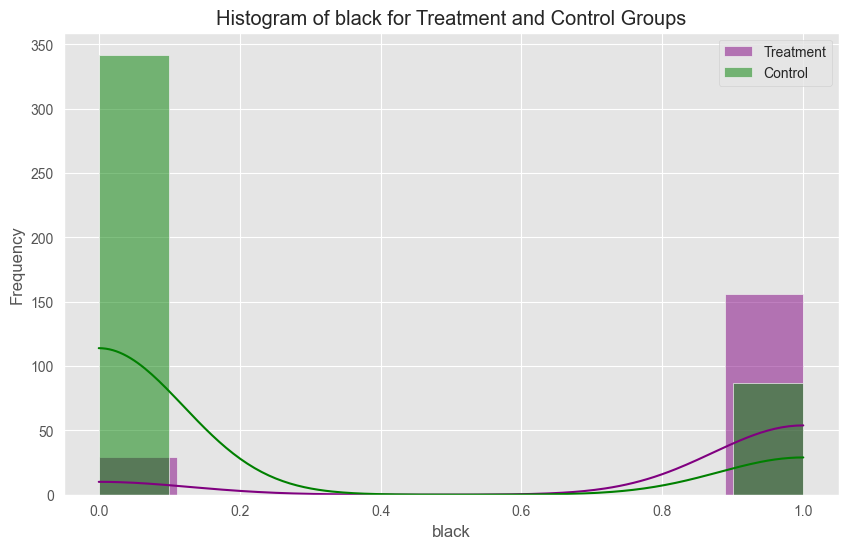

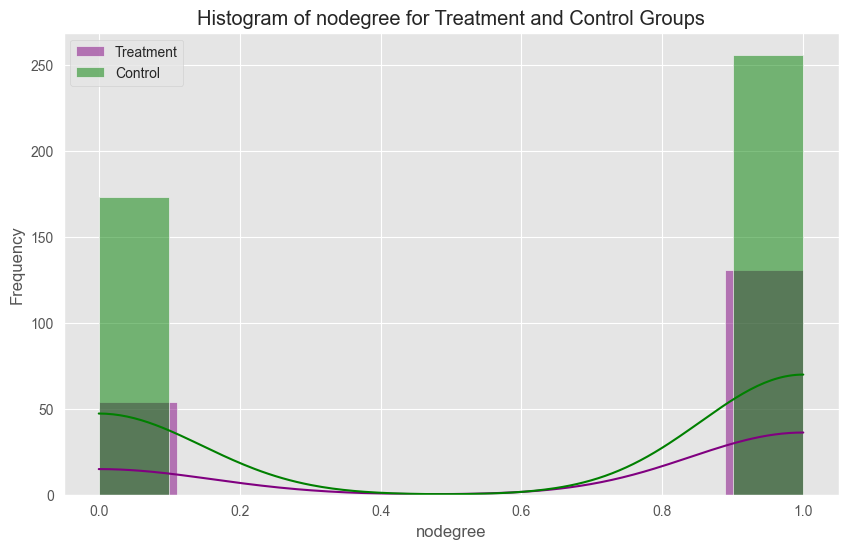

In [9]:
imbalanced = smd_df[smd_df['balance']== 'seriously imbalanced'].index.tolist()
imbalanced_cov = [covariates[c] for c in imbalanced]

for cov in imbalanced_cov:
    plt.figure(figsize=(10,6))
    sns.histplot(lalonde_df[lalonde_df['treat']== 1][cov], color ='purple', label='Treatment', kde=True)
    sns.histplot(lalonde_df[lalonde_df['treat']== 0][cov], color ='green', label='Control', kde=True)

    plt.title(f'Histogram of {cov} for Treatment and Control Groups')
    plt.xlabel(cov)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


-------

<h2>Propensity score matching using logistic regression</h2>

<p>In order to balance the covariates of the control and treatment groups, we will use <strong>matching</strong>.</p>
<p>In Case 7.5 we used the <em>Euclidean distance</em> on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.</p>
<p>We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the <strong>propensity score</strong> helps us do the matching on select features in an efficient way. The key idea is that <em>the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results</em>. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

### Estimating Propensity Scores Using Logistic Regression

A logistic regression model is built to estimate propensity scores, where the outcome variable indicates whether a subject is in the treatment group. All other variables except `re78` are used as covariates. The predicted values output by the model are interpreted as estimated probabilities of being in the treatment group given the covariates.

In [10]:
X = lalonde_df.drop(columns=['treat', 're78'])
y = lalonde_df['treat']

#adds a constant to the model
X = sm.add_constant(X)

#fits the model
model = sm.Logit(y, X)
result = model.fit()

#calculate
propensity_scores = result.predict(X)
lalonde_df['propensity_score'] = propensity_scores
propensity_scores.head()


Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


NSW1    0.638770
NSW2    0.224634
NSW3    0.678244
NSW4    0.776324
NSW5    0.701639
dtype: float64

- A score closer to 1 means you're more likely to be put in the treatment group.
- A score closer to 0 means you're more likely to be put in the conntrol group.

-------

The `.predict()` function is used to obtain the propensity scores of individuals in the dataset. The results are saved under the name `pscore_logit` for later use. Plots are created to show the distribution of propensity scores for both the treatment and control groups.

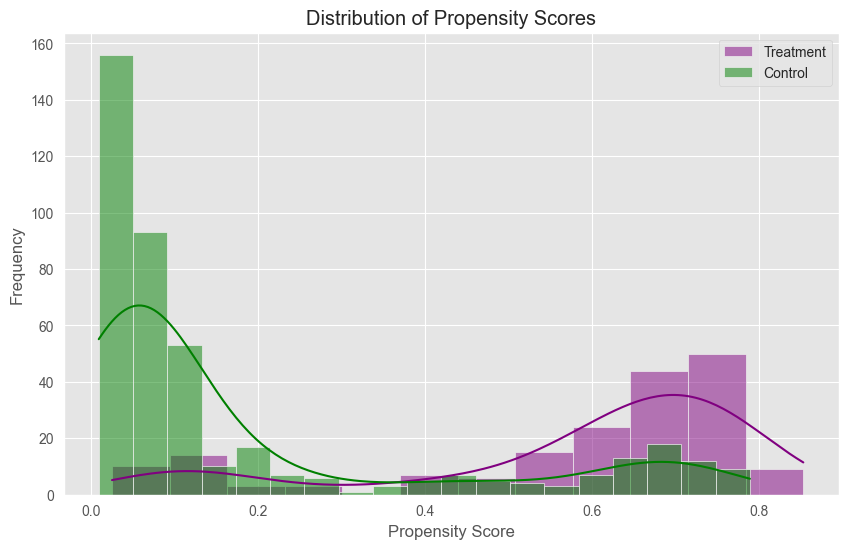

In [11]:
pscore_logit = result.predict(X)
lalonde_df['pscore_logit'] = pscore_logit

plt.figure(figsize=(10, 6))
sns.histplot(lalonde_df[lalonde_df['treat'] == 1]['pscore_logit'], color='purple', label='Treatment', kde=True)
sns.histplot(lalonde_df[lalonde_df['treat'] == 0]['pscore_logit'], color='green', label='Control', kde=True)

plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()



-------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Training k-NN on Control Group Propensity Scores

The propensity scores `pscore_logit` are separated into `treat_pscores` and `control_pscores` for the treatment and control groups, respectively. The `control_pscores` are used to train a k-nearest neighbors (k-NN) algorithm with `k=5`, using Euclidean distance as the metric.

The model is loaded using `knn = neighbors.NearestNeighbors(n_neighbors=5, metric='euclidean')`. The control scores are reshaped using `control_pscores.reshape(-1, 1)`.


In [12]:
from sklearn.neighbors import NearestNeighbors

treat_pscores = lalonde_df[lalonde_df['treat']==1]['pscore_logit'].values
control_pscores = lalonde_df[lalonde_df['treat']==0]['pscore_logit'].values

control_pscores = control_pscores.reshape(-1, 1)
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(control_pscores)

NearestNeighbors(metric='euclidean')

-------

The indices of the five nearest neighbors in the control group are found by applying the `.kneighbors()` method to `treat_pscores`.

In [13]:
treat_pscores = treat_pscores.reshape(-1, 1)
distances, indices = knn.kneighbors(treat_pscores)
print(indices[:5])


[[ 68 386 372 385 375]
 [110  65 338 149 198]
 [369 188 267 380 354]
 [225 195 117 387 411]
 [139 133 276 217 371]]


-------

### Matching Treatment and Control Groups Using Nearest Neighbors

The treatment and control groups are matched using the closest of the five neighbors identified. The output consists of two `DataFrames`, each with 185 rows from `lalonde_df`. The first corresponds to the treatment group, and the second corresponds to the matched control group.


In [14]:
matched_treat = lalonde_df[lalonde_df['treat'] == 1].reset_index(drop=True)

#gett the indices
control_indices = indices[:, 0]

matched_control = lalonde_df.iloc[control_indices].reset_index(drop=True)

# Check
print("Matched treatment group:", matched_treat.shape)
print("Matched control group:" ,matched_control.shape)


Matched treatment group: (185, 12)
Matched control group: (185, 12)


-------

<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

### Visualizing Propensity Score Distributions After Matching

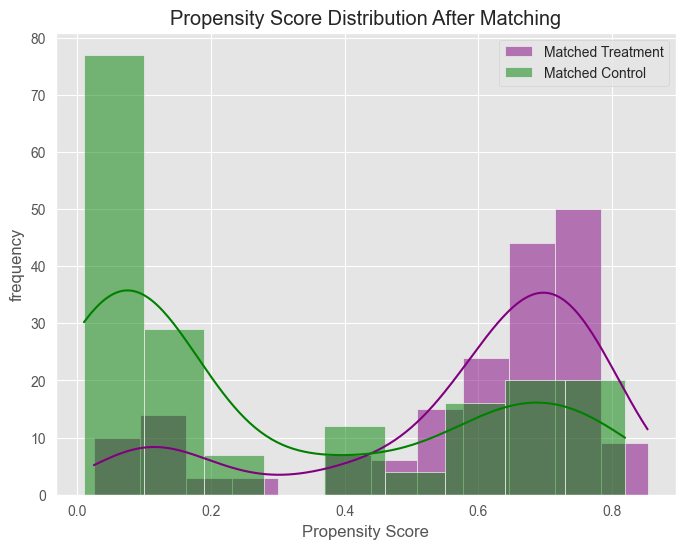

In [15]:
mtreat_pscores = matched_treat['propensity_score']
mcontrol_pscores = matched_control['propensity_score']

plt.figure(figsize=(8, 6))
sns.histplot(mtreat_pscores, label="Matched Treatment", color="purple", kde=True)
sns.histplot(mcontrol_pscores, label="Matched Control", color="green", kde=True)
plt.xlabel("Propensity Score")
plt.ylabel("frequency")
plt.title("Propensity Score Distribution After Matching")
plt.legend()
plt.show()

Balance: 
- Plot 3.2 is a mess almost no overlap, so the groups are way different.
- plot 5 looks better more overlap, so the groups are more alike after matching.

Numbers: 
- Plot 3.2: Control peaks at 160. 
- Plot 5: Control peaks at 80. 
- Maybe there're more people in  control group in Plot 3.2, or matching in Plot 5 cut some out.
- The treatment group is pretty steady, peaking at 40–50 in both.


In conclusion, Plot 3.2 shows the groups are way too different before matching. Plot 5 is better for comparisons because the groups match up more after matching. 





-------

### Assessing Covariate Balance After k-NN Matching

Covariate balance after k-NN matching is assessed by computing the absolute standardized differences in means (ASMD) for each covariate:  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are the means of covariate $x$ in the treatment and control groups after matching, respectively, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are the sample variances treatment and control groups before matching. 

Using the sample variances before matching frees the comparisons of the means after matching from simultaneous changes in variances. 

In [16]:
new_covariates = lalonde_df.drop(columns=['treat', 're78']).columns

mean_t_a = matched_treat[new_covariates].mean()
var_t_b = lalonde_df[lalonde_df['treat']==1][new_covariates].var()
mean_c_a = matched_control[new_covariates].mean()
var_c_b = lalonde_df[lalonde_df['treat']==0][new_covariates].var()

#asmd
asmd = abs(mean_t_a - mean_c_a) / np.sqrt((var_t_b + var_c_b)/ 2)
asmd

age                 0.258672
educ                0.054726
black               1.196431
hispan              0.343791
married             0.660947
nodegree            0.182529
re74                0.545524
re75                0.703832
propensity_score    1.252980
pscore_logit        1.252980
dtype: float64

-------

### Estimating Average Treatment Effect on Wages After Matching

In [17]:
#average effect of treatement
AET = matched_treat['re78'].mean() - matched_control['re78'].mean()
print(AET)

-1739.815592486485


People in the treatment group made $3,499.16 less in 1978 than those in the matched control group.

- The job training program seems to have actually hurt earnings.
- If people who joined the training program had less work experience or other issues, it could explain why their earnings were lower.
- Participants might’ve missed out on income while they were in training
- Things happening in the job market in 1978, like changes in demand or wages, could've affected job opportunities and pay.

-------

<h2>Propensity score matching using decision trees and random forests</h2>

Propensity scores are recalculated using other models such as decision trees and random forests to validate the initial propensity score estimates.

In [18]:
from sklearn.tree import DecisionTreeRegressor

X = lalonde_df.drop(columns=['treat', 're78']) 
y = lalonde_df['treat']

model = DecisionTreeRegressor(max_depth=4)
model.fit(X,y)

lalonde_df['pscore_tree'] = model.predict(X)
lalonde_df[['treat', 'pscore_tree']].head()


,treat,pscore_tree
NSW1,1,0.88172
NSW2,1,0.12500
NSW3,1,0.88172
NSW4,1,0.88172
NSW5,1,0.88172


-------

### Visualizing the Decision Tree Regressor and Estimating Enrollment Probabilities

The decision tree regressor model created in the step above is visualized using a large plot. This plot is used to estimate the probability that:

- A 24-year-old, single, uneducated Hispanic individual who earned $20,000 in 1974 was enrolled in the employment program.
- A Black man with the same characteristics was enrolled.

It is assumed that there were no Black Hispanics in the study.

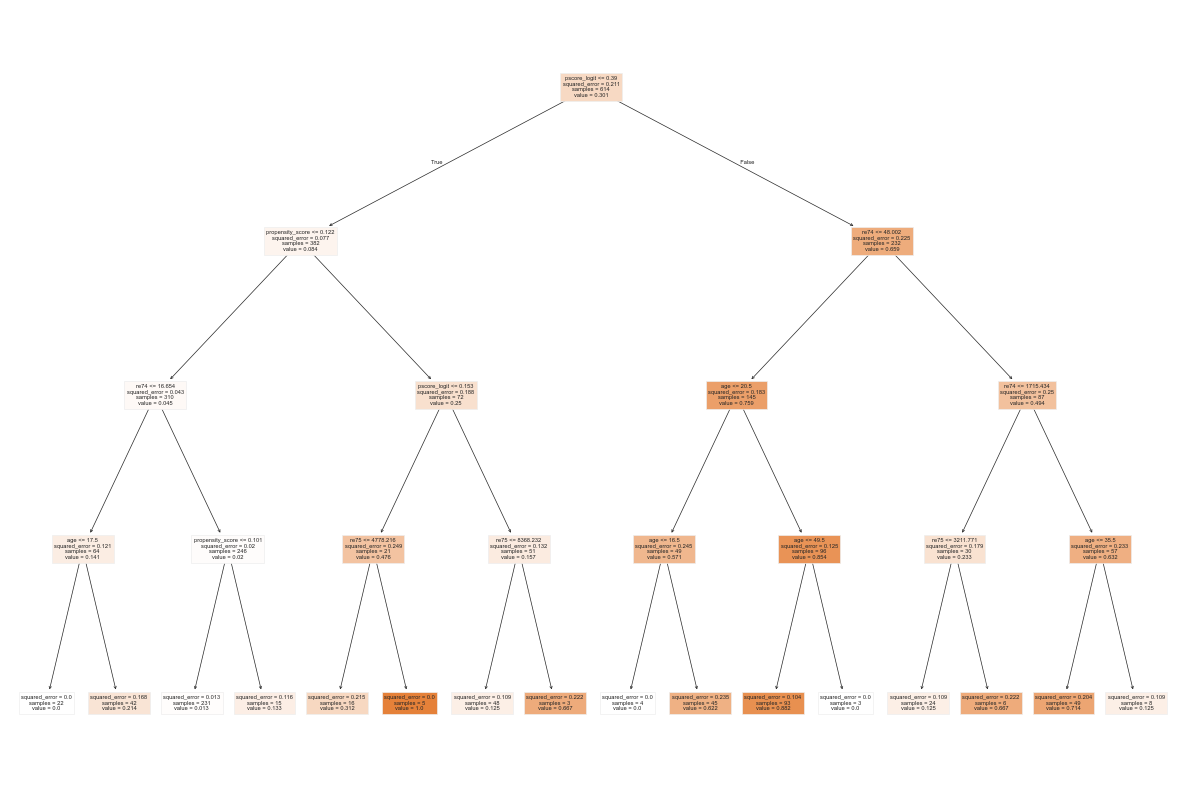

Estimated probability of (Hispanic): 0.012987012987012988
Estimated probability of (Black): 0.012987012987012988


In [19]:
fig = plt.gcf()
fig.set_size_inches(15, 10)
tree.plot_tree(model, filled=True, feature_names=X.columns)
fig.savefig('tree.png')
plt.show()

hispanic_person = [[24, 0, 0, 1, 0, 1, 20000, 0, 0, 0]]
black_person = [[24, 0, 1, 0, 0, 1, 20000, 0, 0, 0]]

# predict pscores
hispanic = model.predict(hispanic_person)[0]
black = model.predict(black_person)[0]

print("Estimated probability of (Hispanic):", hispanic)
print("Estimated probability of (Black):", black)

-------

### Estimating Propensity Scores Using Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
model.fit(X, lalonde_df["treat"])

lalonde_df["pscore_forest"] = model.predict_proba(X)[:, 1]
lalonde_df[["pscore_forest"]].head()


,pscore_forest
NSW1,0.749085
NSW2,0.400224
NSW3,0.752854
NSW4,0.894176
NSW5,0.784907


-------

### Comparing ROC Curves and AUC of Propensity Score Models

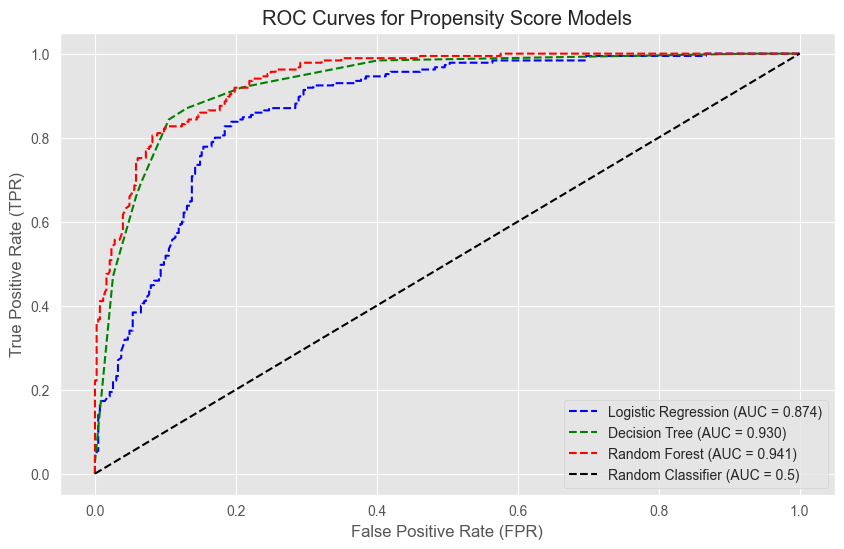

In [21]:
from sklearn.metrics import roc_curve, auc

y = lalonde_df["treat"]

fpr_logit, tpr_logit, _ = roc_curve(y, lalonde_df["pscore_logit"])
auc_logit = auc(fpr_logit, tpr_logit)

fpr_tree, tpr_tree, _ = roc_curve(y, lalonde_df["pscore_tree"])
auc_tree = auc(fpr_tree, tpr_tree)

fpr_forest, tpr_forest, _ = roc_curve(y, lalonde_df["pscore_forest"])
auc_forest = auc(fpr_forest, tpr_forest)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {auc_logit:.3f})", linestyle='--', color='blue')
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {auc_tree:.3f})", linestyle='--', color='green')
plt.plot(fpr_forest, tpr_forest, label=f"Random Forest (AUC = {auc_forest:.3f})", linestyle='--', color='red')


plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Propensity Score Models")
plt.legend()
plt.show()


- Random Forest performed the best (AUC = 0.978)  because AUC values is closer to 1

-------


<p>The statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>" is evaluated.</p>
</blockquote>
<p>An explanation is provided discussing whether this statement is true or false. </p>

False, because;
- AUC is useful for evaluating a classifier but does not guarantee better matching or balance. The real test of a good propensity score model is whether it leads to balanced covariates after matching..

-------

### Matching and Treatment Effect Estimation Using Alternative Propensity Scores

In [22]:
# matching for pscore_tree
t_pscores_tree = lalonde_df[lalonde_df['treat'] == 1]['pscore_tree'].values
c_pscores_tree = lalonde_df[lalonde_df['treat'] == 0]['pscore_tree'].values

c_pscores_tree = c_pscores_tree.reshape(-1, 1)
knn_tree = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_tree.fit(c_pscores_tree)

#find the indices of the nearest neighbors for treatment group
t_pscores_tree = t_pscores_tree.reshape(-1, 1)
distances_tree, indices_tree = knn_tree.kneighbors(t_pscores_tree)

#matching control group based on the nearest neighbors
m_treat_tree = lalonde_df[lalonde_df['treat'] == 1].reset_index(drop=True)
control_indices_tree = indices_tree[:, 0]
m_control_tree = lalonde_df.iloc[control_indices_tree].reset_index(drop=True)


print("Matched treatment group(tree):", m_treat_tree.shape)
print("Matched control group (tree):", m_control_tree.shape)


Matched treatment group(tree): (185, 14)
Matched control group (tree): (185, 14)


In [23]:
# matching for pscore_forest
t_pscores_forest = lalonde_df[lalonde_df['treat'] == 1]['pscore_forest'].values
c_pscores_forest = lalonde_df[lalonde_df['treat'] == 0]['pscore_forest'].values

c_pscores_forest = c_pscores_forest.reshape(-1, 1)
knn_forest = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_forest.fit(c_pscores_forest)

#infd the indices of the nearest neighbors for treatment group
t_pscores_forest = t_pscores_forest.reshape(-1, 1)
distances_forest, indices_forest = knn_forest.kneighbors(t_pscores_forest)

#matching control group based on the nearest neighbors
m_treat_forest = lalonde_df[lalonde_df['treat'] == 1].reset_index(drop=True)
control_indices_forest = indices_forest[:, 0]
m_control_forest = lalonde_df.iloc[control_indices_forest].reset_index(drop=True)


print("Matched treatment group shape (forest):", m_treat_forest.shape)
print("Matched control group shape (forest):", m_control_forest.shape)


Matched treatment group shape (forest): (185, 14)
Matched control group shape (forest): (185, 14)


In [24]:
#for pscore_tree
mean_t_a_tree = m_treat_tree[new_covariates].mean()
var_t_b_tree = lalonde_df[lalonde_df['treat'] == 1][new_covariates].var()
mean_c_a_tree = m_control_tree[new_covariates].mean()
var_c_b_tree = lalonde_df[lalonde_df['treat'] == 0][new_covariates].var()

asmd_tree = abs(mean_t_a_tree - mean_c_a_tree) / np.sqrt((var_t_b_tree + var_c_b_tree) / 2)

#for pscore_forest
mean_t_a_forest = m_treat_forest[new_covariates].mean()
var_t_b_forest = lalonde_df[lalonde_df['treat'] == 1][new_covariates].var()
mean_c_a_forest = m_control_forest[new_covariates].mean()
var_c_b_forest = lalonde_df[lalonde_df['treat'] == 0][new_covariates].var()

asmd_forest = abs(mean_t_a_forest - mean_c_a_forest) / np.sqrt((var_t_b_forest + var_c_b_forest) / 2)

print("ASMD after matching (decision tree):", asmd_tree)
print("ASMD after matching (random forest):", asmd_forest)

ASMD after matching (decision tree): age                 0.155322
educ                0.446561
black               1.337187
hispan              0.307603
married             0.132189
nodegree            0.205345
re74                0.070231
re75                0.014521
propensity_score    1.469047
pscore_logit        1.469047
dtype: float64
ASMD after matching (random forest): age                 0.928386
educ                0.161988
black               0.886766
hispan              0.054283
married             1.057515
nodegree            0.000000
re74                0.486878
re75                0.188972
propensity_score    1.124415
pscore_logit        1.124415
dtype: float64


In [25]:
#AET for pscore_tree and forest
AET_tree = m_treat_tree['re78'].mean() - m_control_tree['re78'].mean()
AET_forest = m_treat_forest['re78'].mean() - m_control_forest['re78'].mean()

print("AET (Decision Tree):", AET_tree)
print("AET (Random Forest):", AET_forest)


AET (Decision Tree): -502.33953999999903
AET (Random Forest): 1708.7095245945957


-------

### Analyzing Poor Performance of Decision Tree Regressor in Covariate Balancing

The reasons behind the decision tree regressor’s poor performance in balancing covariates between treatment and control groups are analyzed. By examining the distances of the ten nearest neighbors obtained from the `.kneighbors()` method applied to the decision tree propensity scores, insights are drawn on why these distances impact covariate balance.


In [26]:
tree_pscores = lalonde_df['pscore_tree'].values.reshape(-1, 1)

knn_tree = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn_tree.fit(tree_pscores)

distances_tree, indices_tree = knn_tree.kneighbors(tree_pscores[lalonde_df['treat'] == 1])

print(distances_tree[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


The decision tree regressor didn’t do a good job of balancing the covariates because the propensity scores for the treated units are either very close or exactly the same. This is shown by the zero distances in the kneighbors() output. Basically, the model didn’t really separate the treated units well when it came to their propensity scores. Because:

- Zero distances between the treated units mean the model is giving the same propensity score to a bunch of them. This results in poor matching between treated and control units because they aren’t being differentiated properly
- For the matching to work well, the propensity scores need to be distinct so the model can find good pairs between treated and control units. When the scores are too close or the same, the model can't make effective matches, which messes up the covariate balance.

Essentially, because the decision tree doesn't create enough variation in the propensity scores, it ends up mismatching treated and control units, which messes up the balance of the covariates.

-------